# <center> Homework 3: Problem 1 </center>
#### <center> Anxhelo Xhebraj xhebraj.1643777@studenti.uniroma1.it </center>
#### <center> {25 Nov .. 9 Dec} 2018 </center>

In [1]:
%load_ext blackcellmagic
%matplotlib inline

In [2]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import time

np.seterr(divide="ignore", invalid="ignore")

from collections import Counter

from IPython.display import Image

from ipywidgets import interact

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.preprocessing import normalize

from spherecluster import SphericalKMeans

seed = 42


def plot(X_2, skm, save_filepath):
    plt.figure(figsize=(16, 10))
    plt.scatter(
        X_2[:, 1],
        X_2[:, 0],
        c=[plt.get_cmap("tab20")(l) for l in skm.labels_],
        alpha=0.8,
        cmap=plt.get_cmap("tab20"),
    )

    patches = []
    for i in set(skm.labels_):
        patches.append(
            mpatches.Patch(color=plt.get_cmap("tab20")(i), label="c" + str(i))
        )
    plt.legend(handles=patches)
    plt.savefig(save_filepath)
    plt.show()


## Dataset to Tf-Idf vectors
We use the `preprocessed_announcements.tsv` of the last homework which contains for each line the normalized tokens of the corresponding document. The Tf-Idf vectorizer will produce the normalized representation of the documents.

In [3]:
tfidf_vec = TfidfVectorizer(lowercase=False)

X = None
with open("../data/preprocessed_announcements.tsv") as f:
    X = tfidf_vec.fit_transform(f.readlines())

dense_X = X.toarray()

### 2D SVD projection of the vectors
We visualize the dataset projecting it into 2D through SVD. Given the linearity of the projection and the high dimensionality of the tfidf representation it is possible to spot outliers and have an overview of the dataset.

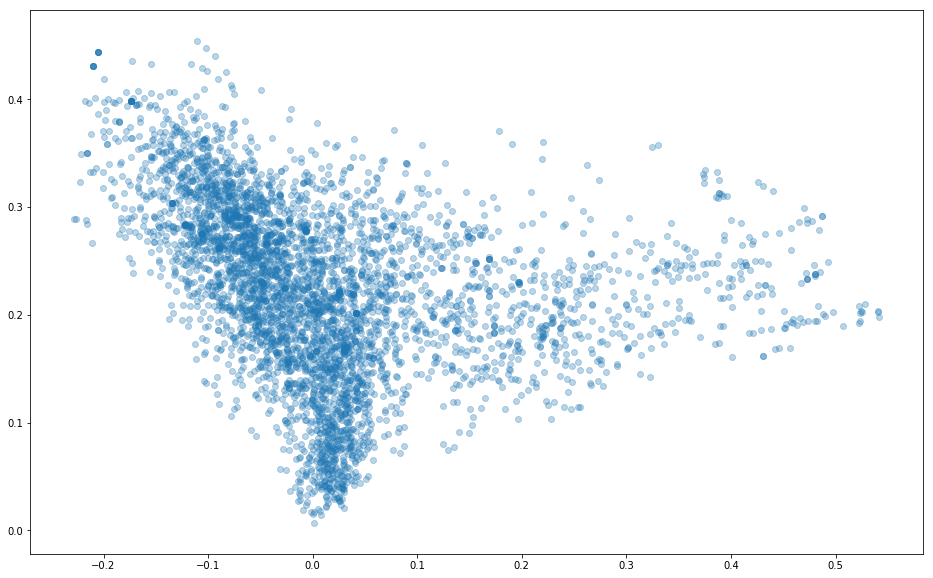

In [4]:
X_2_svd = TruncatedSVD(n_components=2, random_state=seed).fit_transform(dense_X)
plt.figure(figsize=(16, 10))
plt.scatter(X_2_svd[:, 1], X_2_svd[:, 0], alpha=0.3)
plt.show()

### TSNE projection

Another useful projection that is applied is tSNE which is a non-linear projection technique that allows to visualize high dimensional cluster in a 2D plane. Although this can only be applied thanks to the moderate size of the dataset it can still be used to carefully evaluate our findings.

Given the time complexity of the algorithm we first project through SVD our data onto the first 100 components and then apply tSNE.

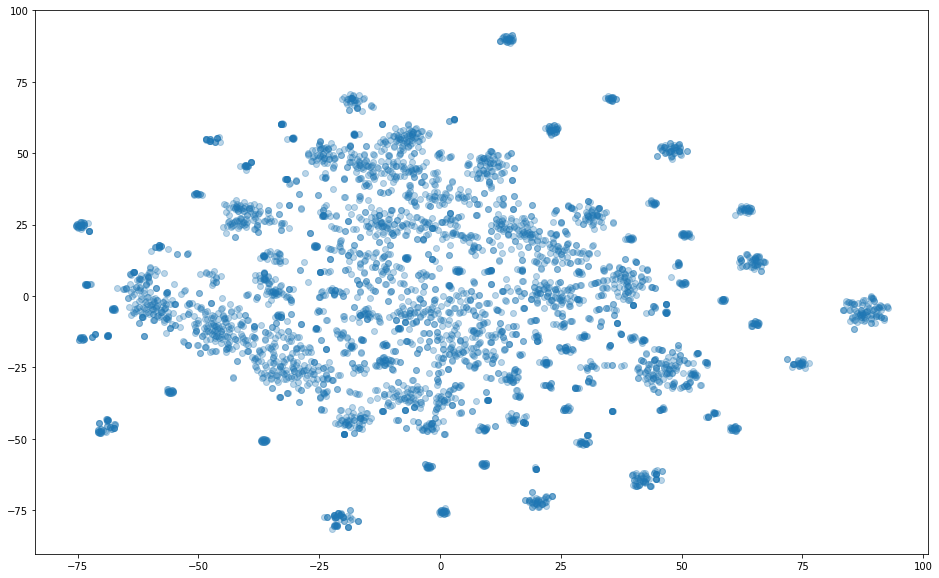

In [5]:
X_2_tsne = TSNE(perplexity=30, n_iter=1200).fit_transform(
    normalize(TruncatedSVD(n_components=100, random_state=seed).fit_transform(X))
)

plt.figure(figsize=(16, 10))
plt.scatter(X_2_tsne[:, 0], X_2_tsne[:, 1], alpha=0.3)
plt.show()

## Perform Spherical KMeans for multiple $k$ s

In order to perform clustering using cosine distance as a distance metric we can use a *Spherical KMeans* implementation of which algorithm is similar to KMeans except in that Spherical KMeans normalizes the centers found after the expectation step. This is similar to using the cosine distance as cost function when vectors are normalized.

The algorithm is run for multiple values of $k$ to later choose which of them provides a satisfactory result.

When choosing $k$ we should take into consideration the size of the dataset ($4424$ items), the diversity of the documents (which can be considered scarce given the fact that documents belong to the same category on kijiji) and the presence of near duplicates. Although duplicates could have been removed we chose not to do so by the fact that such information can provide a hint, maybe superficial, over the goodness of the clusters.

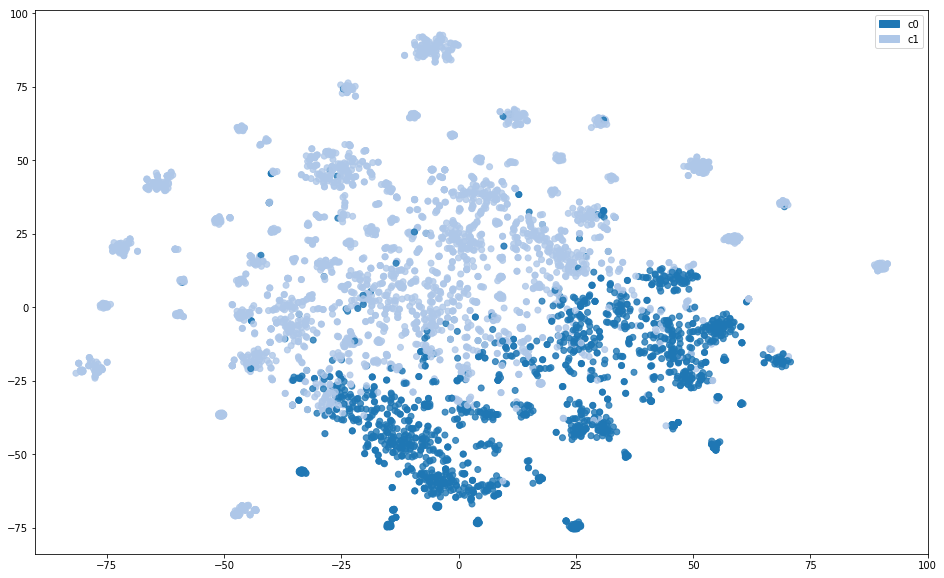

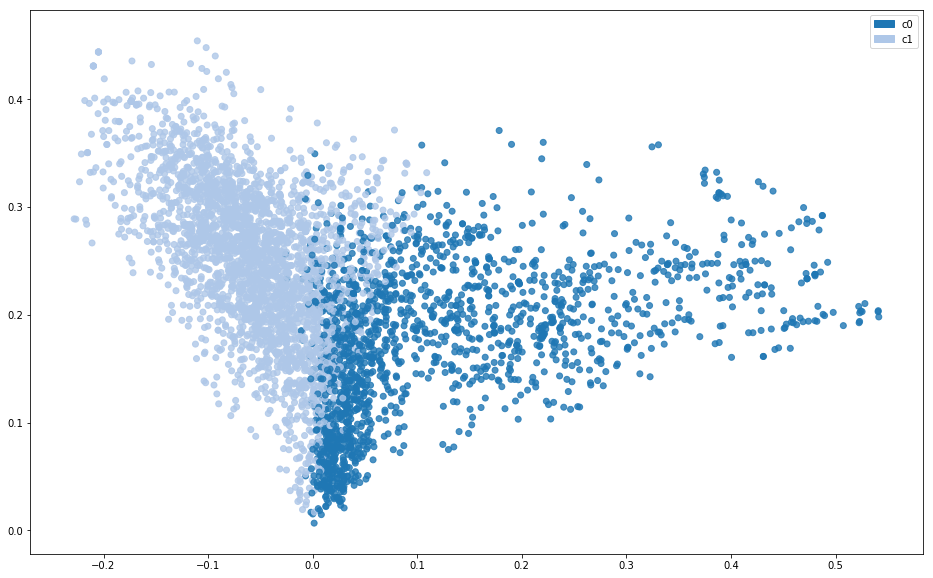

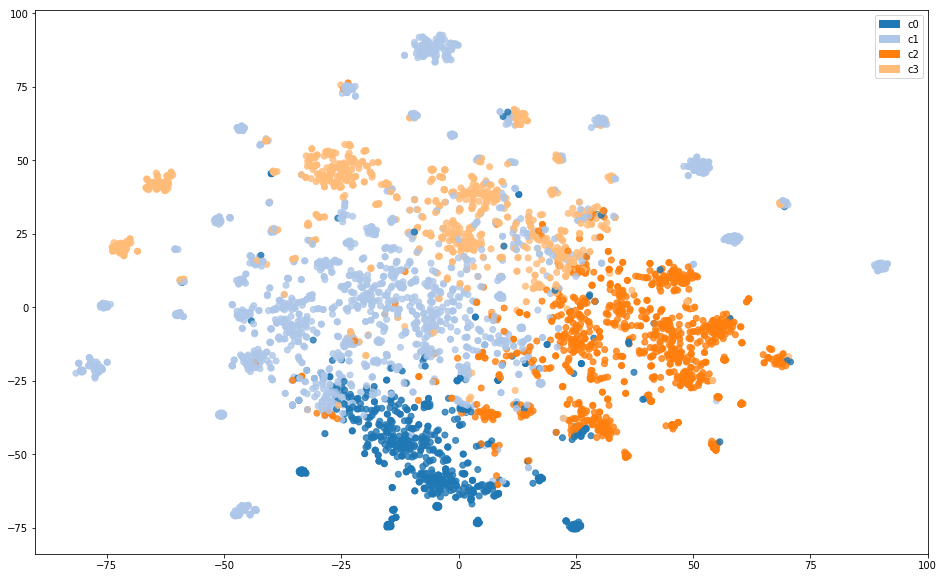

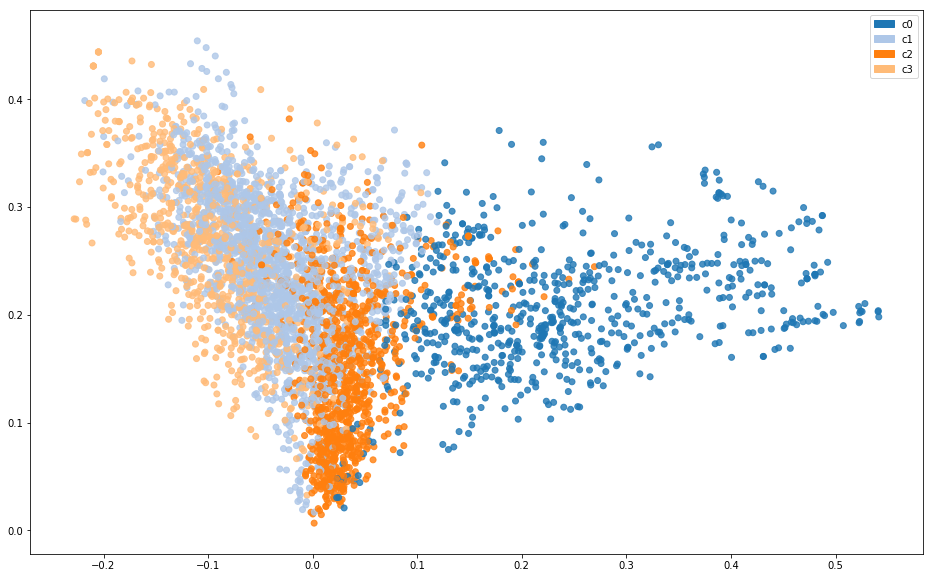

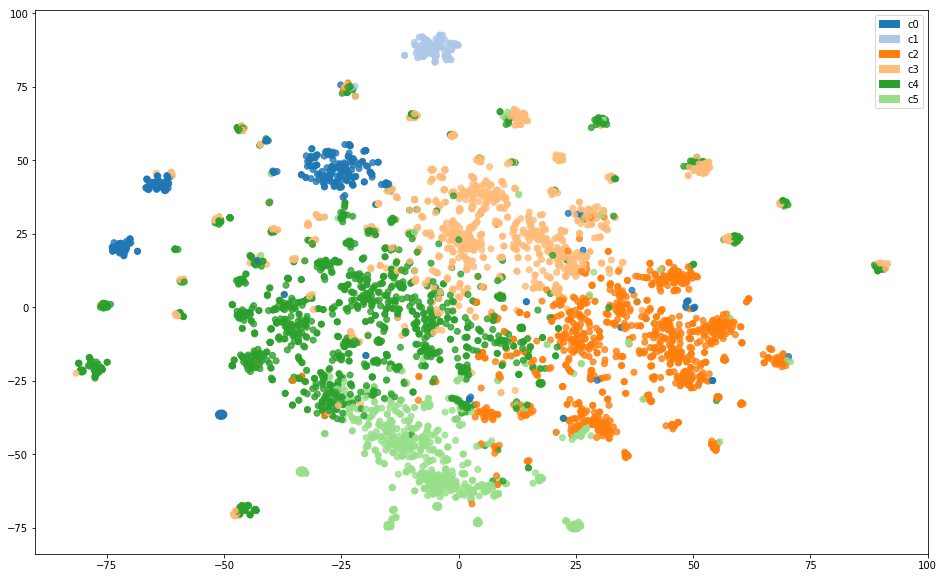

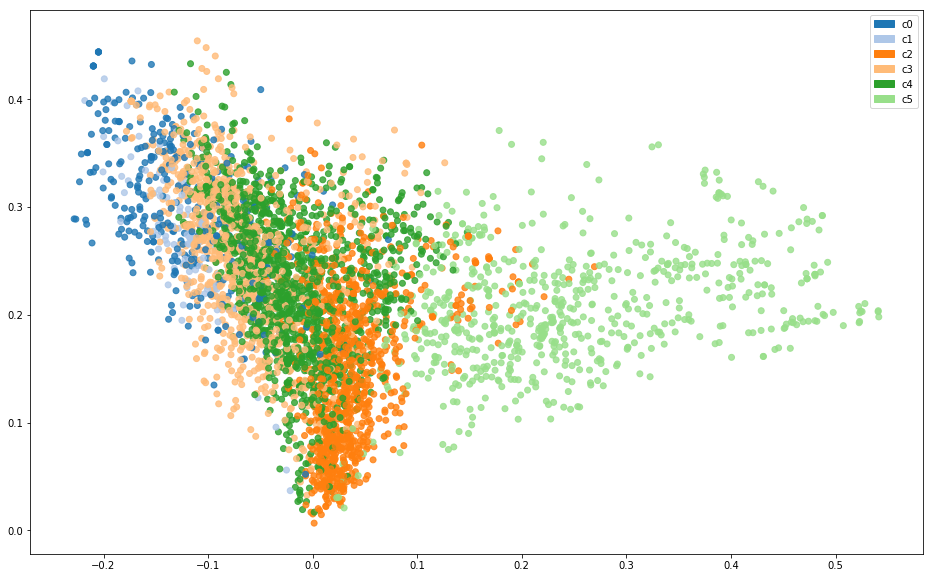

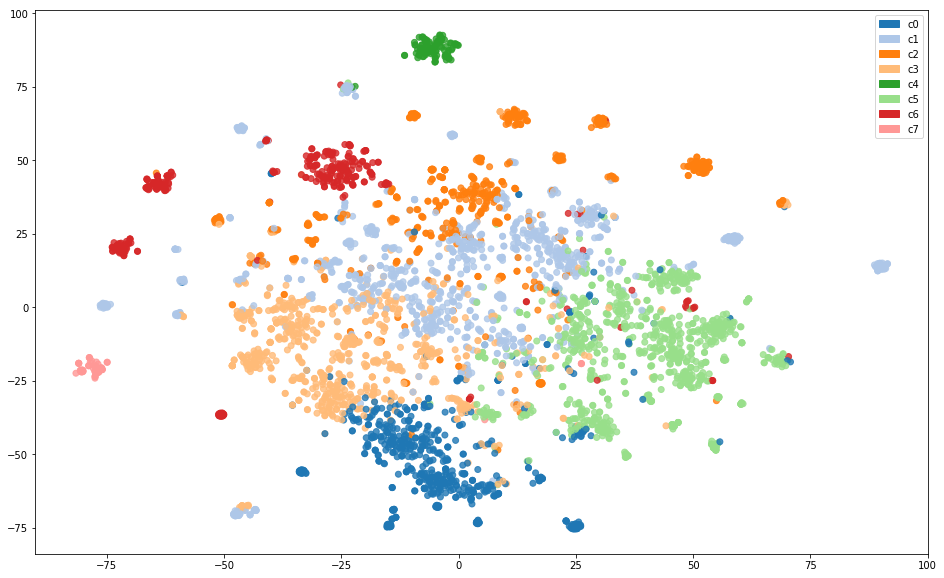

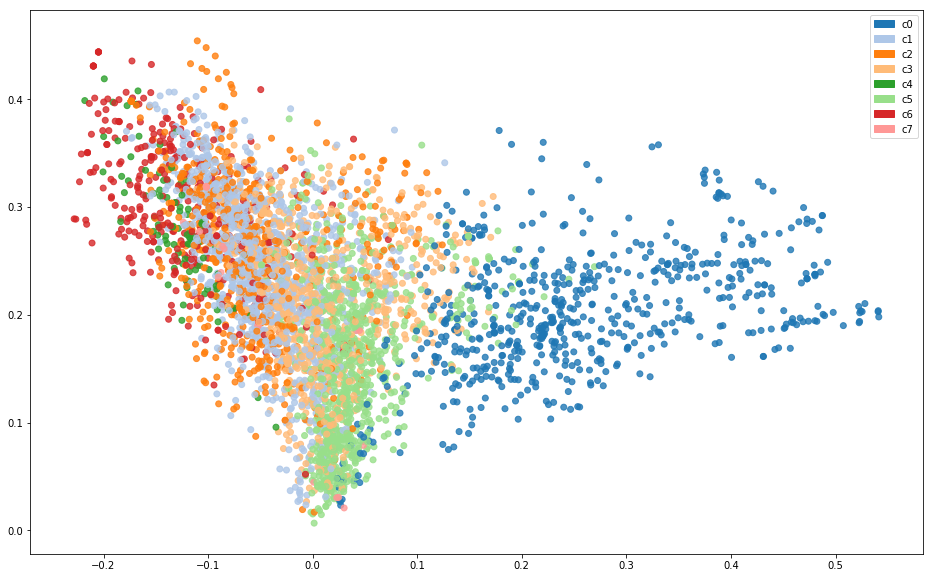

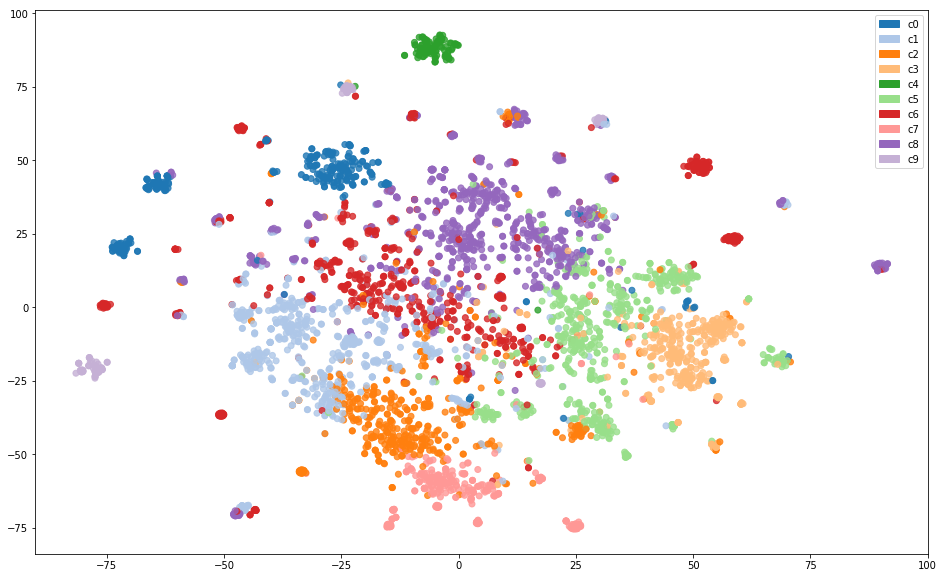

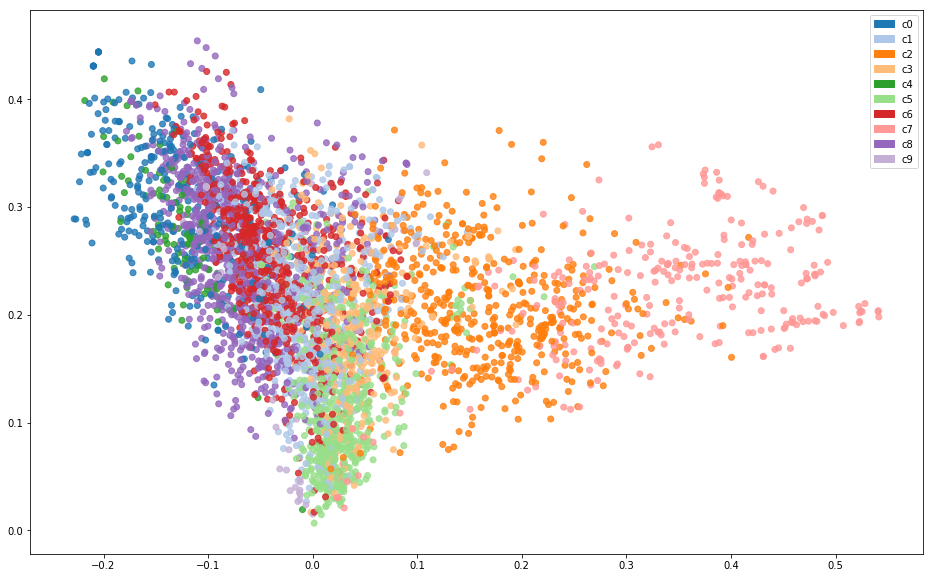

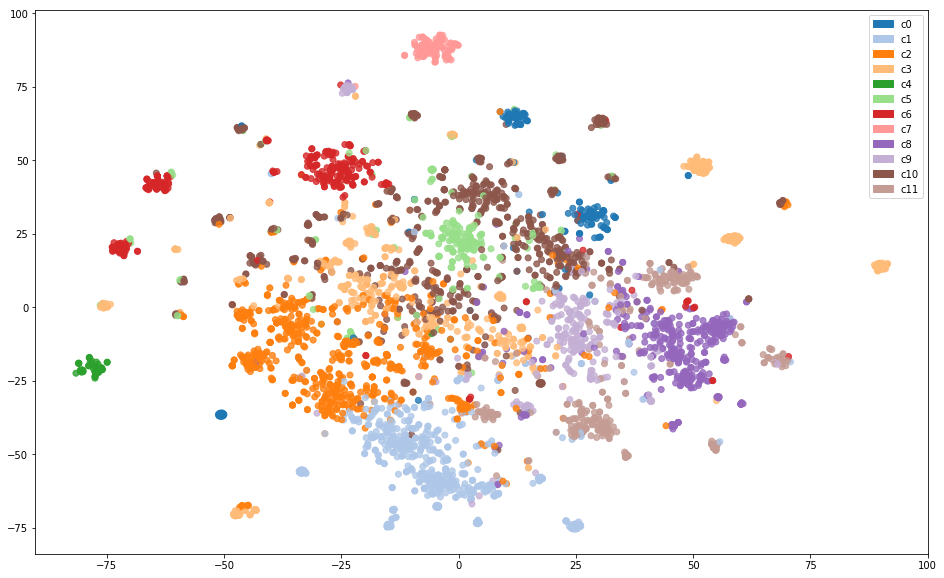

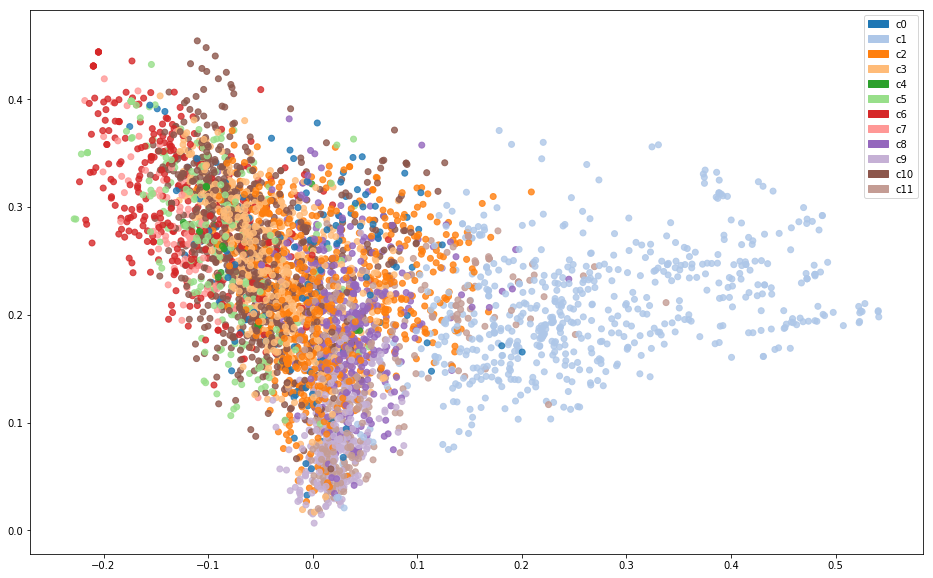

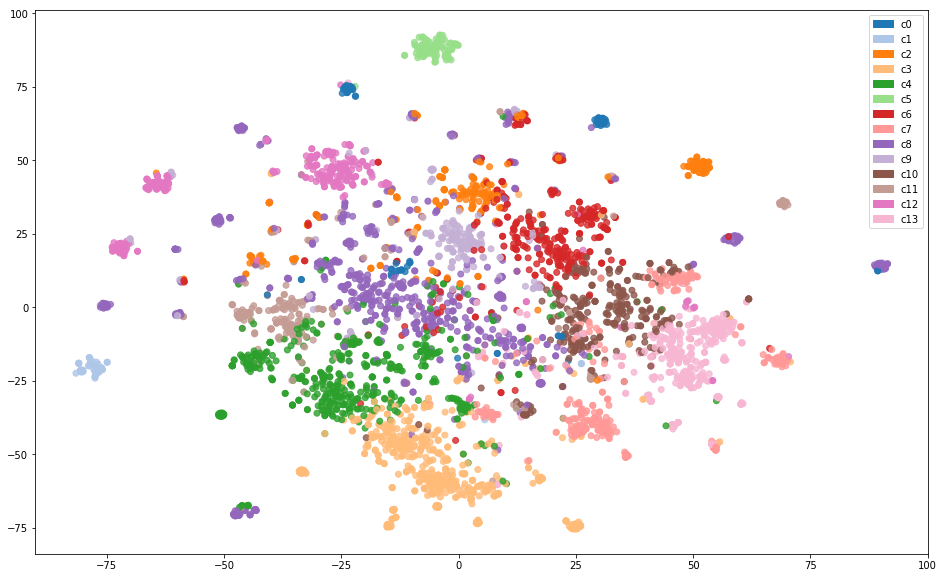

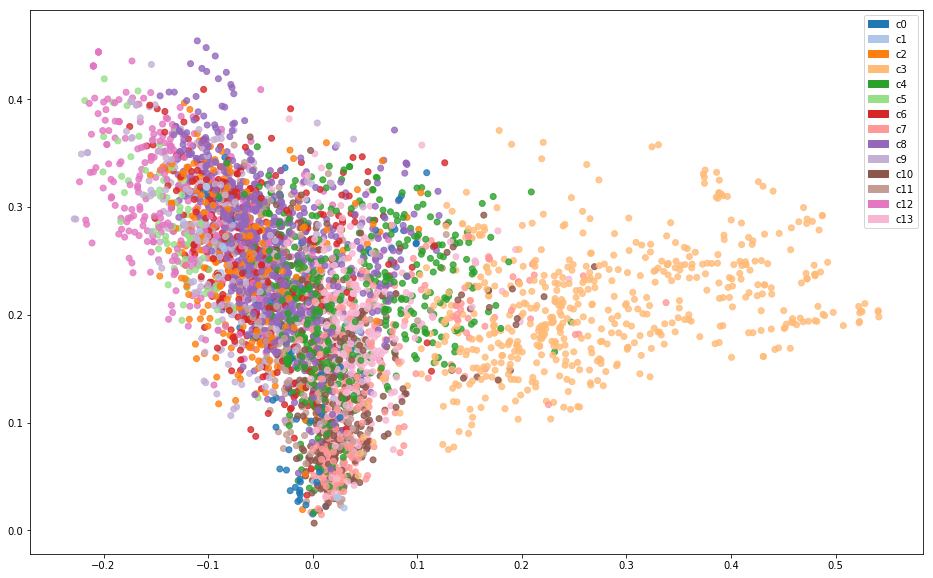

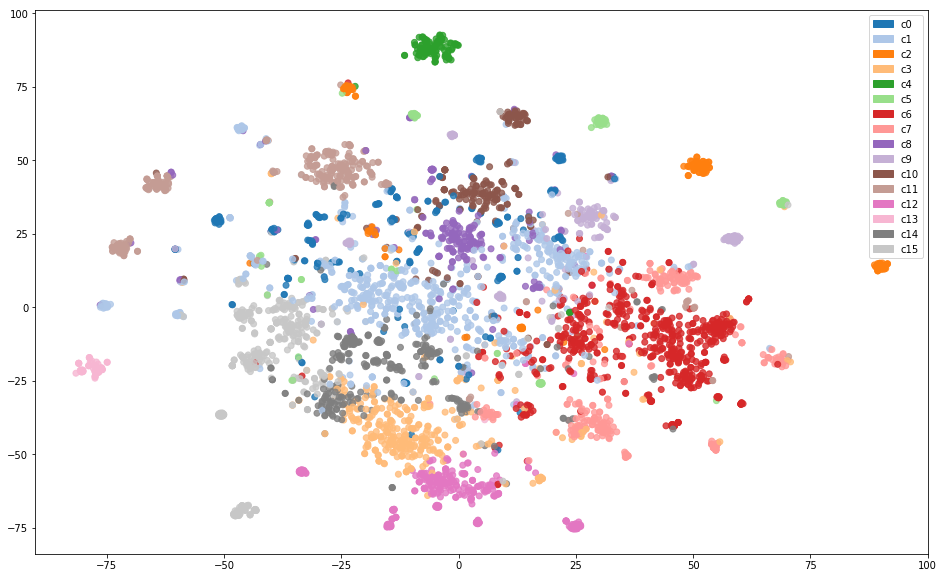

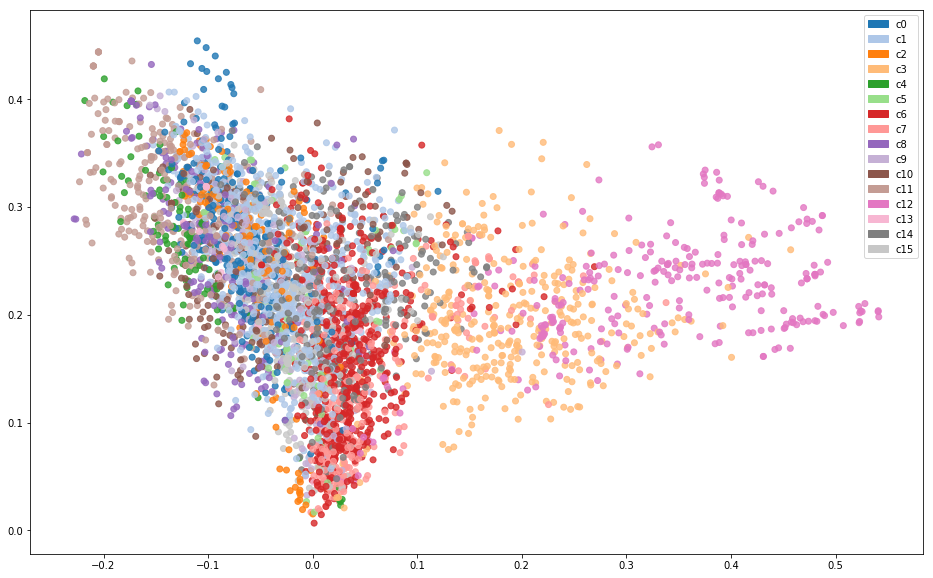

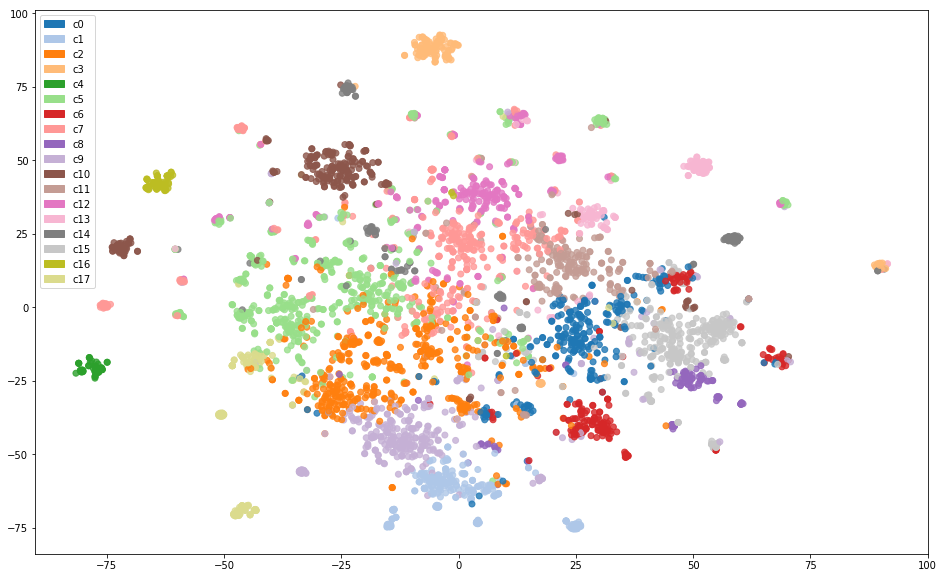

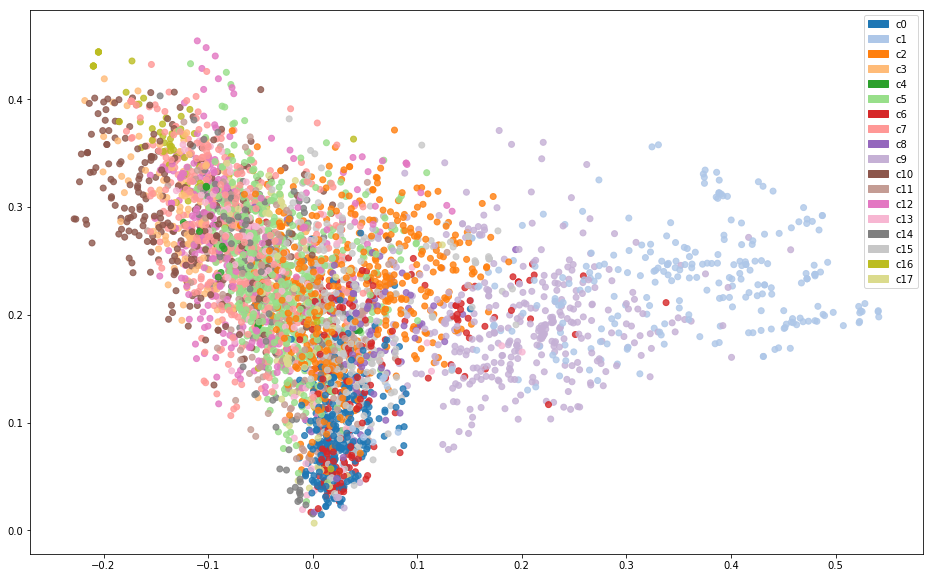

[9.090930990960342, 8.615273443252736, 7.379431992495462, 6.925476939140252, 7.05095273138348, 6.761188607456817, 6.728874391048814, 6.665178210307939, 6.396754536328416, 5.9188396433138175, 5.862079370001457, 5.837784594066183, 5.725696663186609, 5.840538083585112, 5.501143031672064, 5.443212997442034, 5.429641045715301, 5.346094945088957, 5.118901233778794, 5.107845682086152, 5.115749598782765, 5.18198299381294, 4.885158823877226, 4.984498816834985, 4.7395143945561715, 4.817210249955455, 4.798760036822888, 4.660537455484326, 4.582756849681337, 4.606655449600246, 4.62787335643199, 4.7399062791722475, 4.606009508088249, 4.601696567834149, 4.590914865350725, 4.517394792323974, 4.473184189047292, 4.400768674193752, 4.382338067841882, 4.4146213336343365, 4.3213286592284526, 4.31643650541662, 4.31267369210322, 4.30284048453369, 4.282420527054394, 4.186360716236999, 4.275636941084118, 4.110261288091656, 4.290315043527534]
[0.025183503348637823, 0.02127245508216054, 0.028401192242421554, 0.0

In [6]:
davies_scores = []
silhouette_scores = []
for k in range(2, 100, 2):
    skm = SphericalKMeans(n_clusters=k, random_state=seed).fit(X)
    if k <= 19:
        plot(X_2_tsne, skm, "images/tsne" + str(k // 2 - 1) + ".png")
        plot(X_2_svd, skm, "images/svd" + str(k // 2 - 1) + ".png")
    davies_scores.append(davies_bouldin_score(dense_X, skm.labels_))
    silhouette_scores.append(
        silhouette_score(dense_X, skm.labels_, random_state=seed, metric="cosine")
    )

print(davies_scores)
print(silhouette_scores)


Text(0,0.5,'silhouette_score')

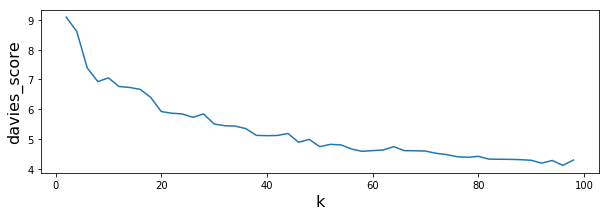

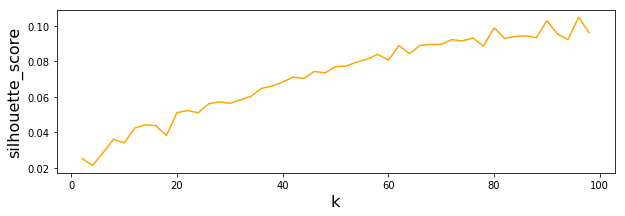

In [7]:
plt.figure(figsize=(10, 3))
k = [i for i in range(2,100,2)]
plt.plot(k, davies_scores)

plt.xlabel('k', fontsize=16)
plt.ylabel('davies_score', fontsize=16)

plt.figure(figsize=(10,3))
plt.plot(k, silhouette_scores, color='orange')
plt.xlabel('k', fontsize=16)
plt.ylabel('silhouette_score', fontsize=16)

The *Davies-Bouldin* score significantly drops up to $k = 16$ and then continues decreasing at a lower rate suggesting $k$ to be lower than 20 while the silhouette score just shows a steady increase in value as $k$ grows.

In [8]:
def g(k):
    print("\rdavies_bouldin_score:", davies_scores[k["new"] // 2 - 1], end="")


def f(k):
    return Image(filename="./images/tsne" + str(k // 2 - 1) + ".png")


inp = widgets.IntSlider(min=2, max=16, step=2, value=1)
interact(f, k=inp)
print("davies_bouldin_score:", davies_scores[0], end="")
inp.observe(g, "value")


interactive(children=(IntSlider(value=2, description='k', max=16, min=2, step=2), Output()), _dom_classes=('wi…

davies_bouldin_score: 9.090930990960342

## Observe clusters for $k = 16$

In order to evaluate the clusters produced we take the top scoring dimensions according to TfIdf for each center of each cluster.

In [9]:
k = 16
start = time.time()
skm = SphericalKMeans(n_clusters=k, random_state=seed).fit(X)
print(f"Computed in {time.time() - start}")
centroids = skm.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vec.get_feature_names()
sizes = Counter(skm.labels_)
for i in range(k):
    print("Cluster {} (size {}):".format(i,sizes[i]), end='')
    for ind in centroids[i, :20]:
        print(' {}'.format(terms[ind]), end='')
    print()

Computed in 84.73050236701965
Cluster 0 (size 273): con per dei conoscenza roma dati milano del personali esperienza della autorizzazione trattamento lâ sensi lavoro 196 java lgs offerta
Cluster 1 (size 683): conoscenza del sviluppo per software con dei della programmatore esperienza una lavoro capacità php nel informatica team che delle ambito
Cluster 2 (size 144): and f2 dalla sia relatech servizi dei informatica f2informatica the territorio dal per milano opera soluzioni corsico sede propri nell
Cluster 3 (size 366): candidatura per inviarci clicca sottostante tua link vedi modalità sito sul web tecnico inviare con informatico nel azienda esperienza settore
Cluster 4 (size 104): management movia realtà come spa facility decennio crede investe competitiva fornitore articolata velocemente ampia proponendosi espressa flessibile strutturata gamma momento
Cluster 5 (size 100): edit data roma proconsul milano oracle all per art esclusivamente sono indicate dati riferimento commerciale cui

In [10]:
!grep 'alten'        ../data/preprocessed_announcements.tsv | wc -l         # cluster 13
!grep 'movia'        ../data/preprocessed_announcements.tsv | wc -l         # cluster 4
!grep 'relatech\|f2' ../data/preprocessed_announcements.tsv | wc -l         # cluster 2

58
100
96


<hr/>
The size of the clusters found are well distributed except for few cases. An interesting result is that some of the clusters contain all the announcements from a given company while other clusters show specific skills and tools frequently used in the italian IT job market (Backend development in Java/Spring, Windows Stack, System Administration, Mobile Development in Android/iOS, "marketing/social media manager", Design/Photoshop).

The presence of broad clusters comes from the "noise" produced by irrelevant terms such as "sviluppo", "flessibile", "esperienza" and indicates absence of diversity in the job market or at least in their description.

### Clustering the projected dataset

In [11]:
from pprint import pprint

start = time.time()
proj_X = TruncatedSVD(n_components=50, random_state=seed).fit_transform(X)
skm_proj = SphericalKMeans(n_clusters=k, random_state=seed).fit(proj_X)
print(f"Computed in {time.time() - start}")
print("davies_bouldin_score: " + str(davies_bouldin_score(dense_X, skm_proj.labels_)))

clusters_X = []
clusters_proj_X = []

for j in range(k):
    clusters_X.append(set(np.where(skm.labels_ == j)[0]))
    clusters_proj_X.append(set(np.where(skm_proj.labels_ == j)[0]))

sims = []

for j in range(k):
    curr = []
    for i in range(k):
        curr.append(len(clusters_X[j] & clusters_proj_X[i]) / len(clusters_X[j]))
    sims.append(curr)


Computed in 0.9812874794006348
davies_bouldin_score: 6.2927460718048644


By first applying SVD projection on the first 50 components and then Spherical KMeans the computation time is significantly reduced also obtaining a better Davies-Bouldin score.

In [12]:
cluster_docs = X[np.where(skm_proj.labels_ == 0)].toarray()
centroids = np.mean(cluster_docs, axis = 0)
for i in range(1, k):
    cluster_docs = X[np.where(skm_proj.labels_ == i)].toarray()
    center = np.mean(cluster_docs, axis = 0)
    centroids = np.vstack((centroids, center))

centroids = normalize(centroids)
centroids = centroids.argsort()[:, ::-1]
terms = tfidf_vec.get_feature_names()
sizes = Counter(skm_proj.labels_)
for i in range(k):
    print("Cluster {} (size {}):".format(i,sizes[i]), end='')
    for ind in centroids[i, :20]:
        print(' {}'.format(terms[ind]), end='')
    print()

Cluster 0 (size 359): dati con dei 196 del per lgs personali autorizzazione java roma trattamento sensi inviare esperienza sviluppo milano torino conoscenza competenze
Cluster 1 (size 353): candidatura per inviarci clicca sottostante vedi tua link modalità sito sul web tecnico inviare con esperienza nel azienda settore mail
Cluster 2 (size 618): del per con conoscenza dei della sviluppo software che nel delle una esperienza capacità clienti ambito lavoro milano alla team
Cluster 3 (size 418): java conoscenza sviluppo developer php con sviluppatore esperienza javascript web per programmatore del end lavoro spring framework della dei milano
Cluster 4 (size 211): net conoscenza sql microsoft asp sviluppo programmatore del server con framework per esperienza sviluppatore developer web javascript dei mvc applicazioni
Cluster 5 (size 244): grafico designer grafica photoshop per video graphic adobe illustrator web con conoscenza 3d indesign programmi stampa pubblicitario comunicazione cerca c

Differently from the previous case, the clusters found in the truncated SVD representation of the dataset are bigger in size and more general although with some exceptions. Indeed, in this case the announcements from the f2informatica company form their own cluster (Cluster 7). Moreover a new cluster is identified composed only by english announcements (Cluster 9).

To better observe this phenomena we decided to "measure" how clusters for the complete dataset differ from their truncated SVD representation clusters. For each of the clusters of the complete dataset we compute the percentage of its documents present in the truncated SVD clusters.

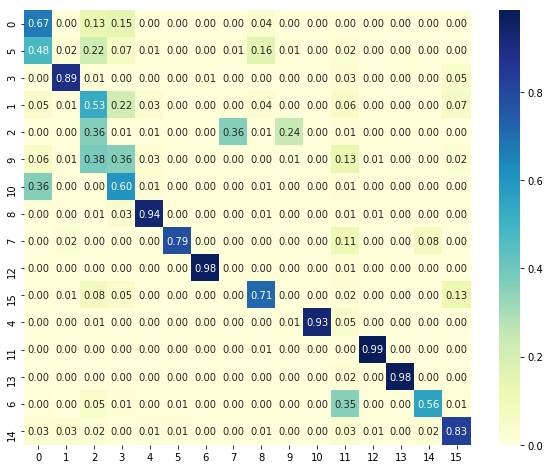

In [13]:
import seaborn as sns

sims = np.array(sims)
order = []
for a in sims:
    order.append(a.argmax())

ordered = np.array(order).argsort()
ordered_sims = [sims[i] for i in ordered]

plt.figure(figsize=(10,8))
sns.heatmap(ordered_sims, cmap="YlGnBu", yticklabels=ordered, annot=True, fmt='.2f')

Here we can see that clusters representing announcements of specific companies are present in the truncated SVD clustering (10, 13).

Cluster 2 and 0 of the truncated SVD clustering are formed by a good portion of large clusters of the complete dataset clustering.